In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import MDAnalysis as mda

# MDAnalysis basics

This notebook works through the basic functionality of the python library *MDAnalysis*, which is a great tool for analyzing the results of molecular dynamics simulations. It uses the files in the directory `output`, which were generated from an MD simulation of the scorpion peptide from the tutorial described in `md-workshop/examples/setup/tutorial.pdf`.

The [mdanalysis.org](https://www.mdanalysis.org) website is excellent. Specifically, it has a page devoted to [learning how to use the software](https://www.mdanalysis.org/pages/learning_MDAnalysis/). Check it out for more details.

## Load a trajectory

*MDAnalysis* stores simulations in `Universe` objects. A `Universe` requires a file that defines the initial coordinates and topology. We can use `output/traj.gro` for this purpose. We can then trajectory frames into the universe by adding an additional `.xtc` file. 

In [2]:
univ = mda.Universe("output/traj.gro",
                    "output/traj-split0.xtc")

The universe object has a bunch of attributes. We can see what's available by typing `univ.` and then hitting the `TAB` key. Anything with an "i" next to it is data, anything with an "f" is a function for calculating something or editing the universe.  

![tooltip](tooltip.png)

For example, `univ.atoms` gives me access to the atoms in the simulation.

In [ ]:
univ.atoms

The universe has 12,480 atoms. We can access the trajectory using the `trajectory` attribute.

In [ ]:
univ.trajectory

This tells us the simulation has 100 frames. 

We can load in a trajectory split across files by sending in a list of trajectory files.

In [ ]:
univ = mda.Universe("output/traj.gro",
                    ["output/traj-split0.xtc",
                     "output/traj-split1.xtc"])
univ.trajectory

The trajectory now has 200 frames. 

To avoid having to type every file, we can use the built-in python module `glob` to search for files that match a pattern. The following creates a list of all of the xtc files in `output`. 

In [ ]:
import glob 
xtc_files = glob.glob("output/traj-split*.xtc")
xtc_files.sort()
print(xtc_files)

We can feed these into our `mda.Universe`, yielding a trajectory with 300 frames.

In [ ]:
univ = mda.Universe("output/traj.gro",xtc_files)    
univ.trajectory

One cool thing about *MDAnalysis* is that it does not load the trajectory into memory--it leaves everything on the hard disk. This means you can analyze trajectories on a vanilla laptop, as long as you have enough disk space. (I usually keep my simulations on an external drive). 

## Select atoms

You can select atoms in much the same way you would select atoms with strings in PyMOL. (It's not exactly the same as PyMOL; the selection language is actually almost identical to that from VMD). A full description of the selection syntax is here: https://userguide.mdanalysis.org/stable/selections.html. Some of the ones I think are the most useful are below.

In [3]:
prot_atoms = univ.select_atoms("protein")                  # select protein atoms
non_protein_atoms = univ.select_atoms("not protein")       # everything but protein
backbone_atoms = univ.select_atoms("protein and backbone") # backbone
prot_or_na = univ.select_atoms("protein or name NA")       # protein or sodium
resid_5 = univ.select_atoms("protein and resid 5")         # residue 5
resid_5to8 = univ.select_atoms("protein and resid 5 to 8") # residue 5-8
any_h = univ.select_atoms("name H*") #any atom whose name starts with H
n_and_o_atoms = univ.select_atoms("type N O") # any atom that is an N or O

# You can get fancy and select atoms near other atoms. This gets every 
# solvent atom (resname SOL) that is within 3.5 angstroms of a protein atom. 
sol_near_prot = univ.select_atoms("resname SOL and (around 3.5 protein)")

# And fancier still using parentheses. Here I've selected water oxygens 
# within 3.5 angstroms of protein.
water_ox_near_prot = univ.select_atoms("(resname SOL and name OW) and (around 3.5 protein)")

Once we have selections, we can calculate features. (Use the `TAB` trick from above on any selection to to discover what you can calculate). For example, the cell below gives us the center of mass of the protein atoms. Quick reminder that in Python, anything that looks like `blah()` or `blah(some_stuff,some_ther_stuff)` calls the function `blah`.

In [ ]:
prot_atoms.center_of_mass()

Another cool feature of these selections is that they can be accessed like lists of atoms. The following two calls give us the number of atoms in the selection (`len(water_ox_near_prot)`) and the identity of the first atom (`water_ox_near_prot[0]`). (For the second example, remember that Python starts its arrays from `0` not `1`.)

In [ ]:
print("Number of atoms is given by length of selection:",len(water_ox_near_prot))
print("The first (0th) atom is:",water_ox_near_prot[0])

## Enumerate over frames

We can enumerate over frames using a standard python loop. The following prints the number of frames (`len` call), then loops through the trajectory. It prints the frame number (`t.frame`) until we reach the 5th frame, at which point we break out of the loop. (It would be annoying to print out all 300 frames!)

In [4]:
print("The trajectory is this long:",len(univ.trajectory))
for t in univ.trajectory:
    print(t.frame)
    if t.frame >= 5:
        print("exiting loop")
        break

The trajectory is this long: 100
0
1
2
3
4
5
exiting loop


## A simple analysis

We now now enough to do a simple analysis. We're going to ask how the number of solvent atoms near the protein changes over the simulation. 

Text(0, 0.5, 'num. water oxygens within 3.5 A of protein')

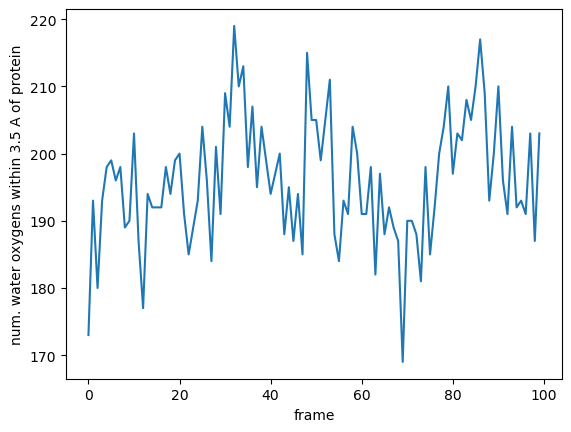

In [5]:
# List to hold results
number_of_nearby_waters = []

# Go over trajectory
for t in univ.trajectory:

    # Select water oxygens near protein
    water_ox_near_prot = univ.select_atoms("(resname SOL and name OW) and (around 3.5 protein)")

    # Count number of atoms in selection
    num_near = len(water_ox_near_prot)

    # Append count to a list
    number_of_nearby_waters.append(num_near)

# Plot the results
plt.plot(number_of_nearby_waters)
plt.xlabel("frame")
plt.ylabel("num. water oxygens within 3.5 A of protein")